Created on Mon Jun 05 12:31:57 2017 by @author: nmtarr

Description: Exploration of using the BISON API to retrieve, filter, and visualize
    species occurrence records.  

NOTE: You must keep the row count low to avoid crashing BISON.  

NOTE: Setting x-ticks for histograms is complicated with matplotlib.  See 
https://stackoverflow.com/questions/27083051/matplotlib-xticks-not-lining-up-with-histogram.

These functions will eventually need to retrieve records based on TSN (I think).

This is the old URL query string that we started with:
    URL = "https://bison.usgs.gov/solr/occurrences/select/?q=\
           -centroid:[%22%22%20TO%20*]%20AND%20year:[2007%20TO%202017]%20\
           AND%20scientificName:%22{0}%20{1}%22&start=0&rows=500&wt=json&\
           fl=coordinateUncertaintyInMeters,eventDate,latlon,TSNs,\
           basisOfRecord,scientificName,year,ITIScommonName,centroid,\
           generalComments"

In [1]:
def queryBISON(scientificName, startYear, endYear, ItisTSN=[], rows=500):
    '''
    (string, integer, integer, list, integer) -> dataframe
    
    This function queries the BISON API to retrieve occurrence records for the 
        passed species.  For each record, latitude, longitude, coordinate
        uncertainty (m), event date, basis of record, and associated Itis TSN
        codes are retrieved and placed in a pandas dataframe.  Uses the pandas
        and requests packages.
    
    Arguments:
    scientificName -- The species' scientific name
    startYear -- First year you are interested in.
    endYear -- Last year you are interested in.
    ItisTSN -- Not enabled yet, but will eventually facilitate querying based
        on ITIS codes instead of scientific names.
    rows -- The max number of records to return in case you need to limit the 
        query size.
    
    Example:
    >>>dfBISONRecords = queryBISON(scientificName="Terrapene carolina")
    '''
    import pandas as pd
    import requests
    print(scientificName)
    
    ################################# Build a query URL string for the solr API
    ###########################################################################
    baseURL = "https://bison.usgs.gov/solr/occurrences/select/?q="
    fields = "coordinateUncertaintyInMeters,eventDate,latlon,TSNs, \
              basisOfRecord, scientificName,year,ITIScommonName,centroid, \
              generalComments"
    qryString = """-centroid:["" TO *] 
                   AND year:[{3} TO {4}] \
                   AND scientificName:"{0}" \
                   &start=0&rows={1}&wt=json&fl={2}"""
    URL = baseURL + qryString
    URL = URL.format(scientificName, rows, fields, startYear, endYear)

    ################################################################# Run query
    ###########################################################################
    try:
        results = requests.get(URL).json()
    except:
        print(URL)
        
    #################################### Build a filtered data frame of records
    ###########################################################################
    # empty dataframe for collecting results
    spDF = pd.DataFrame()
    # fill out dataframe
    for x in results["response"]["docs"]:
        try:
            responseDF = pd.DataFrame()
            responseDF.loc[0, "scientificName"] = x["scientificName"]
            responseDF.loc[0, "coordinateUncertaintyInMeters"] = x["coordinateUncertaintyInMeters"]
            responseDF.loc[0, "eventDate"] = x["eventDate"]
            responseDF.loc[0, "lat"] = x["latlon"].split(",")[1]
            responseDF.loc[0, "lon"] = x["latlon"].split(",")[0]
            responseDF.loc[0, "basisOfRecord"] = x["basisOfRecord"]
            responseDF.loc[0, "TSNs"] = x["TSNs"]
            responseDF.loc[0, "year"] = x["year"]
            #responseDF.loc[0, "generalComments"] = x["generalComments"]
            #responseDF.loc[0, "centroid"] = x["centroid"]
            #responseDF.loc[0, "ITIScommonName"] = x["ITIScommonName"]
            spDF = spDF.append(responseDF, ignore_index=True)
        except Exception as e:
            print("\tERROR -- skipped record")
            print("\t" + str(e))
    print("\n")
    
    ############################################### Return dataframe of records
    ###########################################################################
    return spDF

In [4]:
def visualizeBISON(dataframe):       
    '''
    (dataframe) -> figures printed to ipython
    
    For use with queryBISON, which returns a dataframe that can be fed into this
        function.  This function creates graphs that show the locations of 
        BISON occurrence records, percentage of each basis of record, and 
        coordinate uncertainty.
        
    Arguments:
    dataframe -- a dataframe produced by the queryBISON function.
    
    Notes:
    Not all histograms will have x ticks that line up with bins correctly because
        of the dynamic nature of some fields' values (year and coordinate
        uncertainty). See https://stackoverflow.com/questions/27083051/matplotlib-xticks-not-lining-up-with-histogram.
    
    Example:
    >>> table1 = queryBISON(scientificName="Terrapene carolina")
    >>> figure1 = visualizeBISON(table1)
        
    '''
    %matplotlib inline
    import matplotlib.pyplot as plt
    from mpl_toolkits.basemap import Basemap
    import matplotlib.gridspec as gridspec
    import numpy as np
    
    fig = plt.figure(figsize=(12.5, 12))
    G = gridspec.GridSpec(3,3)
    fontsize = 10
    
    ################################################### Title in the first spot
    ###########################################################################
    ax0 = plt.subplot(G[0, 0], frameon=False)
    ax0.text(.2,.85, sp ,  fontsize=20)
    ax0.text(.2,.75, str(len(table)) + " records",  fontsize=16)
    # Hide the axis that automatically get drawn so background is blank.
    ax0.axes.get_yaxis().set_visible(False)
    ax0.axes.get_xaxis().set_visible(False)
       
    ########################################################### Plot the points
    ###########################################################################
    # create basemap.  Mercator used.  Is that correct?
    m = Basemap(ax=plt.subplot(G[0, 1:]), projection='merc', resolution='c',
                llcrnrlat=20,urcrnrlat=55,
                llcrnrlon=-126,urcrnrlon=-66,
                lat_ts=20,)
    m.drawcoastlines()
    #m.drawstates()
    m.drawcountries()
    m.fillcontinents(color='green',lake_color='aqua')
    m.drawmapboundary(fill_color='aqua')
    
    # plot points
    xyDF = table.filter(["lat", "lon"], axis=1)
    xyDF["lat"] = pd.to_numeric(xyDF.lat)
    xyDF["lon"] = pd.to_numeric(xyDF.lon)
    for i in table.index:
        row = xyDF.iloc[i]
        m.plot(row.lon, row.lat, 'k.', alpha=0.5, latlon=True)
        
    ############################################## Graph uncertainty histograms
    ###########################################################################
    try:
        uncertain = table.filter(["coordinateUncertaintyInMeters"], axis=1)
        uncertain["coordinateUncertaintyInMeters"] = pd.to_numeric(uncertain.coordinateUncertaintyInMeters)
        uncertain1 = uncertain.fillna(0)
        missingCount = len(uncertain1[uncertain1.coordinateUncertaintyInMeters == 0])
        
        # All
        uncertain2 = uncertain1[uncertain1.coordinateUncertaintyInMeters > 0]
        if len(uncertain2) > 0:
            uncertainPlot2 = uncertain2.plot(ax=plt.subplot(G[2, 0]), 
                                             kind="hist", legend=False,
                                             title=str(len(uncertain)-missingCount) + 
                                             " Records with Uncertainty Values",
                                             fontsize=fontsize)
            uncertainPlot2.set_xlabel("Coordinate Uncertainty (m)")
            # < 1km
            uncertain3 = uncertain2[uncertain2.coordinateUncertaintyInMeters < 1000]
            bins = np.arange(0, 1100, 100)-50
            uncertainPlot3 = uncertain3.plot(ax=plt.subplot(G[2, 1]), 
                                             kind="hist", legend=False,
                                             title=str(len(uncertain3)) + 
                                             " Records with Uncertainty < 1km",
                                             fontsize=fontsize,
                                             bins=bins,
                                             xlim=(0,1100))
            uncertainPlot3.set_xlabel("Coordinate Uncertainty (m)")
            plt.xticks(range(-100, 1100, 200))
            # < 100m
            uncertain4 = uncertain2[uncertain2.coordinateUncertaintyInMeters < 100]
            bins = np.arange(0, 110, 10)-5
            uncertainPlot4 = uncertain4.plot(ax=plt.subplot(G[2, 2]), 
                                             kind="hist", legend=False,
                                             title=str(len(uncertain4)) + 
                                             " Records with Uncertainty < 100 m",
                                             fontsize=fontsize, 
                                             bins=bins,
                                             xlim=(0,110))
            uncertainPlot4.set_xlabel("Coordinate Uncertainty (m)")
            plt.xticks(range(0, 110, 10))
        else:
            print("Problem summarizing coordinate uncertainty")
    except:
        print("Coordinate Uncertainty Failed")
    
    #################################################### Graph basis of records
    ###########################################################################
    try:
        basis = table.filter(["basisOfRecord"], axis=1)
        basisPlot = basis.basisOfRecord.value_counts().plot.pie(ax=plt.subplot(G[1, 2]),
                                                    title="Basis of Records", 
                                                    autopct='%.0f',
                                                    fontsize=fontsize)
        basisPlot.set_ylabel("")
    except Exception as e:
        print(e)
        
    #################################################### Graph year of records
    ###########################################################################
    try:
        year = table.filter(["year"], axis=1)
        yearPlot = year.plot(ax=plt.subplot(G[1, 0]), kind="hist", legend=False, bins=10,
                             color=["orange"], title="Records by Year",
                             fontsize=fontsize)
        yearPlot.set_xlabel("Year")
    except:
        pass
    
    #################################################### Graph month of records
    ###########################################################################
    try:
        dateDF = table.filter(["eventDate"], axis=1)
        dateDF["datetime"] = [pd.to_datetime(d) for d in dateDF.eventDate]
        dateDF["month"] = [d.month for d in dateDF.datetime]
        monthPlot = dateDF.filter(["month"], axis=1)
        bins = np.arange(13)-0.5                             # this enables bins to sit above x ticks, note it's 1 + desired bin number
        monthPlot.plot(ax=plt.subplot(G[1, 1]),
                       kind="hist", legend=False, bins=bins, # note bins
                       color=["red"], title="Records by Month", 
                       fontsize=fontsize, xlim=(0,13)).set_xlabel("Month")      # note limit is 1 + desired bin number
        plt.xticks(range(13))                                # set x ticks with number of bins you want + 1
    except Exception as e:
        print(e)
    
    print("NOTE: Some histogram bins are not correctly alligned with x tick marks.")
    print("NOTE: The map's projection is probably not a perfect match to the records.")
    
    plt.tight_layout()
    return fig

Run the query for each species in the species list

Mustela frenata
	ERROR -- skipped record
	'coordinateUncertaintyInMeters'
	ERROR -- skipped record
	'coordinateUncertaintyInMeters'
	ERROR -- skipped record
	'coordinateUncertaintyInMeters'
	ERROR -- skipped record
	'latlon'
	ERROR -- skipped record
	'latlon'
	ERROR -- skipped record
	'latlon'
	ERROR -- skipped record
	'latlon'
	ERROR -- skipped record
	'latlon'
	ERROR -- skipped record
	'latlon'
	ERROR -- skipped record
	'latlon'
	ERROR -- skipped record
	'latlon'
	ERROR -- skipped record
	'latlon'
	ERROR -- skipped record
	'latlon'
	ERROR -- skipped record
	'latlon'
	ERROR -- skipped record
	'latlon'
	ERROR -- skipped record
	'latlon'
	ERROR -- skipped record
	'latlon'
	ERROR -- skipped record
	'latlon'
	ERROR -- skipped record
	'latlon'
	ERROR -- skipped record
	'latlon'
	ERROR -- skipped record
	'latlon'
	ERROR -- skipped record
	'latlon'
	ERROR -- skipped record
	'latlon'
	ERROR -- skipped record
	'latlon'
	ERROR -- skipped record
	'latlon'
	ERROR -- skipped record
	'latlon'
	ERRO

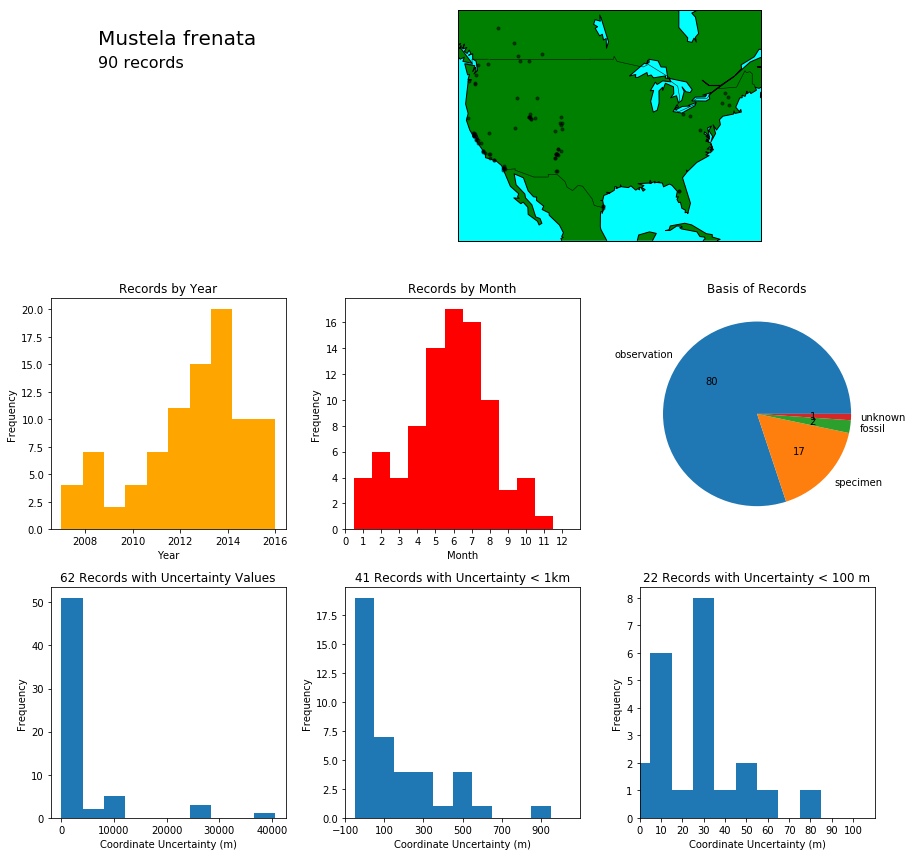

In [7]:
import pandas as pd
pd.set_option('display.width', 1000)

species = ["Mustela frenata"]
for sp in species:
    table = queryBISON(scientificName=sp, startYear=2007, endYear=2017,
                       rows=500)
    table.to_csv("T:/temp/" + sp + ".csv")
    fig = visualizeBISON(table)
    #fig.savefig("T:/temp/{0}.png".format(sp), transparent=False, dpi=400)